In [19]:
import time
import numpy as np
import pandas as po
from tqdm import tqdm
import multiprocessing
import matplotlib.pyplot as plt

In [2]:
df = po.read_csv('data/EnergyConsumption_Theft.csv')
df = df.sample(frac=1).reset_index(drop = True) # shuffle df so that classes are evenly distributed in train-val-test

In [3]:
df = df.drop(['CONS_NO'], axis = 1)

In [4]:
df.isnull().sum().sum()

0

In [5]:
df

,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
0,0,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,...,2.730,3.580000,4.290000,4.390000,5.220000,2.990000,4.63,3.67,5.61,5.01
1,0,1.510000,0.93,1.520000,3.650000,2.77,2.530000,2.70,0.000000,0.00,...,0.615,1.230000,1.250000,1.520000,1.210000,1.230000,1.25,1.22,1.20,1.64
2,0,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,...,1.200,2.550000,0.990000,1.330000,3.180000,4.340000,1.10,1.21,2.97,2.78
3,0,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,...,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00
4,0,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,...,6.080,10.770000,9.020000,4.850000,13.317372,7.310000,11.28,6.88,7.09,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42367,1,4.640000,4.24,7.260000,6.820000,5.32,8.383489,8.07,8.383489,6.71,...,6.550,8.383489,8.383489,8.383489,5.410000,6.650000,6.52,7.09,6.58,5.41
42368,0,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,...,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.02,0.00
42369,0,13.937313,9.40,13.240000,11.440000,7.82,11.460000,9.52,10.580000,8.61,...,9.890,5.540000,4.640000,3.560000,6.690000,5.840000,6.79,5.93,6.48,4.81
42370,0,13.040000,7.89,14.533562,14.533562,6.54,6.820000,6.83,7.190000,9.03,...,13.380,7.960000,11.430000,3.720000,12.620000,4.110000,4.07,4.08,5.04,5.27


In [6]:
df['FLAG'].value_counts()

0    38757
1     3615
Name: FLAG, dtype: int64

In [7]:
df_min = df[df['FLAG'] == 1].reset_index(drop=True)

In [8]:
minor = df_min.drop('FLAG', axis=1).to_numpy()

In [160]:
k = 100

In [161]:
minor.shape

(3615, 1034)

In [162]:
from sklearn.neighbors import NearestNeighbors

In [163]:
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(minor)

In [164]:
distances, indices = nbrs.kneighbors(minor)

In [165]:
indices = indices[:, 1:]

In [166]:
indices.shape

(3615, 100)

In [167]:
def SNN(i, j):
    return len(np.intersect1d(indices[i], indices[j]))

In [168]:
snn_sim = {}

In [169]:
for i in tqdm(range(len(indices))):
    snn_sim[i] = {}
    for j in range(len(indices)):
        snn_sim[i][j] = SNN(i, j)

100%|██████████| 3615/3615 [04:08<00:00, 14.56it/s]


In [170]:
density = {}
for i in range(len(indices)):
    sum = 0
    for j in range(len(indices[i])):
        sum += snn_sim[i][j]
    
    density[i] = sum

In [181]:
density_ratio = {}
for i in range(len(indices)):
    neigh_dens = []
    for j in range(len(indices[i])):
        neigh_dens.append(density[indices[i][j]])
    neigh_dens = np.array(neigh_dens)
    density_ratio[i] = density[i]/np.mean(neigh_dens)

In [189]:
np.mean(np.array(list(density_ratio.values())))

0.9048050819072927

In [188]:
np.std(np.array(list(density_ratio.values())))

0.1572531058272164

(array([ 10.,  29., 115., 257., 595., 831., 892., 637., 209.,  40.]),
 array([0.30716304, 0.40875778, 0.51035253, 0.61194727, 0.71354201,
        0.81513675, 0.91673149, 1.01832623, 1.11992097, 1.22151572,
        1.32311046]),
 <a list of 10 Patch objects>)

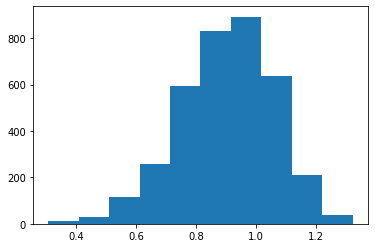

In [191]:
plt.hist(np.array(list(density_ratio.values())))

In [195]:
drT = 0.9 + 0.15*1.5

In [198]:
core_points = []
for i in range(len(density_ratio)):
    if density_ratio[i] > drT:
        core_points.append(i)

In [204]:
def reverse_nearest_neighbours(pt_index):
    rnns = []
    for i in range(len(indices)):
        if i!=pt_index:
            if pt_index in list(indices[i]):
                rnns.append(i)
                
    return rnns

In [206]:
directly_density_reachable_core_points = {}
for cp_index in core_points: #Can't need actual values here
    dds = list(indices[cp_index]) 
    dds += reverse_nearest_neighbours(cp_index)
    
    directly_density_reachable_core_points[cp_index] = dds

In [207]:
clusters = {}

In [ ]:
for cp_index in core_points
    for dds_cp in directly_density_reachable_core_points[cp_index]:
        

In [38]:
SNNs = list(map(SNN, range()))

len(SNNs)

SNNs

start = time.process_time()
for i in range(len(minor)):
    
start = time.process_time()
for i in range(len(minor)):
    for j in range(len(minor)):
        np.intersect1d(indices[i], indices[j])
print(time.process_time() - start)

arr_ind = 23

def knn(arr_ind):
    norms = np.zeros(len(minor),)
    for i in range(len(minor)):
        if arr_ind == i:
            continue
        norms[i] = np.linalg.norm(minor[i]-minor[arr_ind], ord=2)
    
    norms = norms.argsort()
    return list(norms[:k])

p = multiprocessing.Pool()

def calc_norm(i):
    if arr_ind == i:
        return np.inf
    return np.linalg.norm(minor[i]-minor[arr_ind], ord=2)

def knn(arr_ind):    
    
    start = time.process_time()
    #norms = list(map(calc_norm, range(len(minor))))
    norms = p.map(calc_norm, range(len(minor)))
    print(time.process_time() - start)
        
    norms = np.array(norms).argsort()
    
    return list(norms[:k])

minor[1322]

knn_idx = knn(1322)
knn_idx

knn_idx = knn(1322)

minor[knn_idx, :]

minor[knn_idx, :].shape

arr_ind = 23
knns_self = knn(arr_ind) 



for i in range(100):
    snn_mp(i)
snn_mp_out = map(snn_mp, range(100))

snn_mp_out = map(snn_mp, range(len(minor)))

3000/60

def snn(arr_ind):
    knns_self = knn(arr_ind)
    
    snn_sim = []
    for i in tqdm(range(len(minor))):
        if arr_ind == i:
            snn_sim.append([])
        
        else: 
            knns_other = knn(i)
            #snn_sim.append(list(set(knns_other) & set(knns_self))) 
            snn_sim.append(list(set(knns_self).intersection(knns_other))) 
            
    return snn_sim

sims = snn(23)

snn_sim = snn(23)

len(snn_sim)

np.linalg.norm(np.random.randn(100, 1) - np.random.randn(100, 1), ord=2)